In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer, pipeline
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split, StratifiedKFold
import tensorflow as tf
import pandas as pd
from sklearn.utils import class_weight
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Model Kurulumu


In [ ]:
model = TFAutoModelForSequenceClassification.from_pretrained("VRLLab/TurkishBERTweet", num_labels=3, from_pt=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/651 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/652M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("VRLLab/TurkishBERTweet")

tokenizer_config.json:   0%|          | 0.00/352 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.88M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.19M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.77M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

In [ ]:
model.summary()

Model: "tf_roberta_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLaye  multiple                  162251520 
 r)                                                              
                                                                 
 classifier (TFRobertaClass  multiple                  592899    
 ificationHead)                                                  
                                                                 
Total params: 162844419 (621.20 MB)
Trainable params: 162844419 (621.20 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Pipeline Test

In [ ]:
sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, device=0)

test text scenairo



In [ ]:
test_text = "İkbal hiç sevmiyor."

# sentiment pipeline to predict
result = sentiment_pipeline(test_text)

print(f"Text: {test_text}")
print(f"Predicted sentiment: {result[0]['label']}")
print(f"Confidence score: {result[0]['score']:.4f}")

Text: İkbal hiç sevmiyor.
Predicted sentiment: LABEL_0
Confidence score: 0.8019


# Labeled data eğitimi

In [ ]:
file_path2 = '/content/predictions.csv'
df_labeled = pd.read_csv(file_path2)

In [ ]:
df_labeled.head()

,text,predicted_sentiment,confidence_score
0,doların 18 liraya çıktığı gün bu gamepass de p...,1,0.998317
1,arkadaşlar taş gibi makina ama saç traşı için ...,2,0.983468
2,ilk dususte beyni gitti,0,0.998452
3,Ürünü deneme imkanım olmadı ama dün gece verdi...,2,0.997096
4,çagri merkezi ölmüş sanirim gecen hafta 35 mbi...,1,0.998301


In [ ]:
df_labeled.rename(columns={'text': 'content','predicted_sentiment':'sentiment'}, inplace=True)

df_labeled['sentiment'] = pd.to_numeric(df_labeled['sentiment'], errors='coerce')  # Hatalı verileri NaN olarak işleyin

df_labeled = df_labeled.drop(columns=['confidence_score'])

# NaN değerleri temizleyin
df_labeled = df_labeled.dropna()
df_labeled['sentiment'] = df_labeled['sentiment'].apply(lambda x: 0 if x == 19.9 or x == 24.0 else x)
print(f"Etiketlerin aralığı: {df_labeled['sentiment'].min()} - {df_labeled['sentiment'].max()}")

Etiketlerin aralığı: 0 - 2


In [ ]:
df_labeled.head()

,content,sentiment
0,doların 18 liraya çıktığı gün bu gamepass de p...,1
1,arkadaşlar taş gibi makina ama saç traşı için ...,2
2,ilk dususte beyni gitti,0
3,Ürünü deneme imkanım olmadı ama dün gece verdi...,2
4,çagri merkezi ölmüş sanirim gecen hafta 35 mbi...,1


In [ ]:
df_labeled['sentiment'].value_counts().unique()

array([6223, 2811, 2723])

In [ ]:
df_labeled['sentiment'].value_counts()

,count
sentiment,
0,6223
1,2811
2,2723


In [ ]:
df_labeled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11757 entries, 0 to 11756
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   content    11757 non-null  object
 1   sentiment  11757 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 183.8+ KB


In [ ]:
df_labeled['sentiment'] = pd.to_numeric(df_labeled['sentiment'], errors='coerce')  # Hatalı verileri NaN olarak işleyin
# NaN değerleri temizleyin
df_labeled = df_labeled.dropna()

In [ ]:
df_labeled.isnull().sum()

,0
sentiment,0
content,0


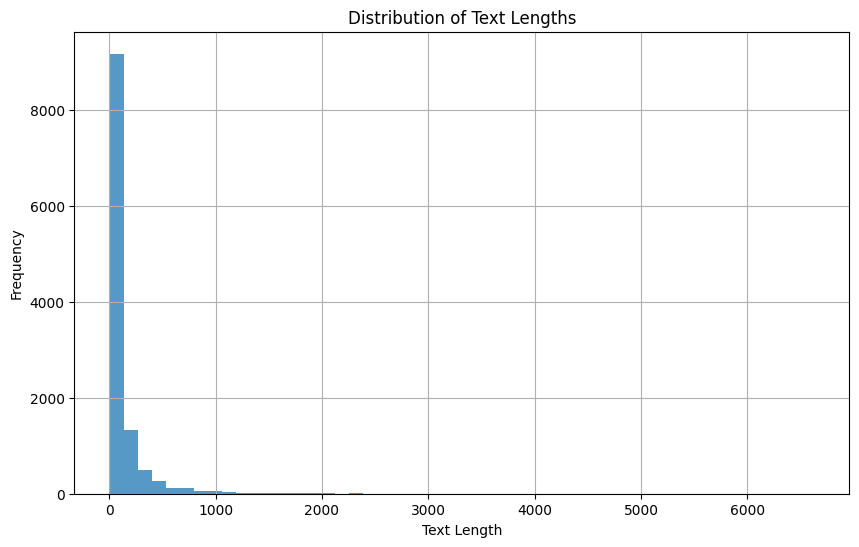

128.54265543931274

In [ ]:
import matplotlib.pyplot as plt

# Calculate the length of each text
df_labeled['Text_Length'] = df_labeled['content'].apply(len)

# Plot the distribution of text lengths
plt.figure(figsize=(10, 6))
plt.hist(df_labeled['Text_Length'], bins=50, alpha=0.75)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Calculate the average text length
average_text_length = df_labeled['Text_Length'].mean()
average_text_length

In [ ]:
sentences = df_labeled.content.values
max_len = 128 #ortalama text uzunluğuna göre

In [ ]:
def tokenize_function(texts):
    encoded = tokenizer(
        list(texts),  # inputların olduğu arrayi string listesine çevirdik
        padding='max_length',
        truncation=True,
        max_length=max_len,
        return_tensors="tf",
        return_attention_mask=True
    )
    return {
        'input_ids': encoded['input_ids'],
        'attention_mask': encoded['attention_mask']
    }


In [ ]:
# train_val, test = train_test_split(df_labeled, test_size=0.15, stratify=df_labeled['sentiment'], random_state=42)
train_val, test = train_test_split(df_labeled, test_size=0.3, stratify=df_labeled['sentiment'], random_state=42)


# 70% train 15% validation
# train, val = train_test_split(train_val, test_size=0.1765, stratify=train_val['sentiment'], random_state=42)  # 0.1765 x 0.85 ≈ 0.15
train, val = train_test_split(train_val, test_size=0.33, stratify=train_val['sentiment'], random_state=42)

print("Training set size:", len(train))
print("Validation set size:", len(val))
print("Test set size:", len(test))

Training set size: 5513
Validation set size: 2716
Test set size: 3528


In [ ]:
# TensorFlow datasetlerini oluşturuyoruz
def create_dataset(df):
    encodings = tokenize_function(df['content'].values)
    return tf.data.Dataset.from_tensor_slices((
        {
            'input_ids': encodings['input_ids'],
            'attention_mask': encodings['attention_mask']
        },
        df['sentiment'].values
    ))

train_dataset = create_dataset(train)
val_dataset = create_dataset(val)
test_dataset = create_dataset(test)

In [ ]:
# Calculate class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train['sentiment']), y=train['sentiment'])
class_weights = dict(enumerate(class_weights))

In [ ]:
# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  # Less aggressive reduction
    patience=2, # Reduce learning rate after 2 epochs of no improvement
    min_lr=1e-7
)



In [ ]:
batch_size = 8

In [ ]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=1e-5,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-8
)

In [ ]:
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

history = model.fit(
    train_dataset.batch(batch_size),
    validation_data=val_dataset.batch(batch_size),
    epochs=20,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr],
)


Epoch 1/20
690/690 [==============================] - 109s 108ms/step - loss: 0.0679 - accuracy: 0.9806 - val_loss: 0.2692 - val_accuracy: 0.9282 - lr: 2.0000e-05
Epoch 2/20
690/690 [==============================] - 47s 69ms/step - loss: 0.0464 - accuracy: 0.9878 - val_loss: 0.3008 - val_accuracy: 0.9275 - lr: 2.0000e-05
Epoch 3/20
690/690 [==============================] - 48s 69ms/step - loss: 0.0232 - accuracy: 0.9937 - val_loss: 0.3828 - val_accuracy: 0.9227 - lr: 2.0000e-05
Epoch 4/20
690/690 [==============================] - 48s 69ms/step - loss: 0.0088 - accuracy: 0.9984 - val_loss: 0.4578 - val_accuracy: 0.9175 - lr: 1.0000e-05


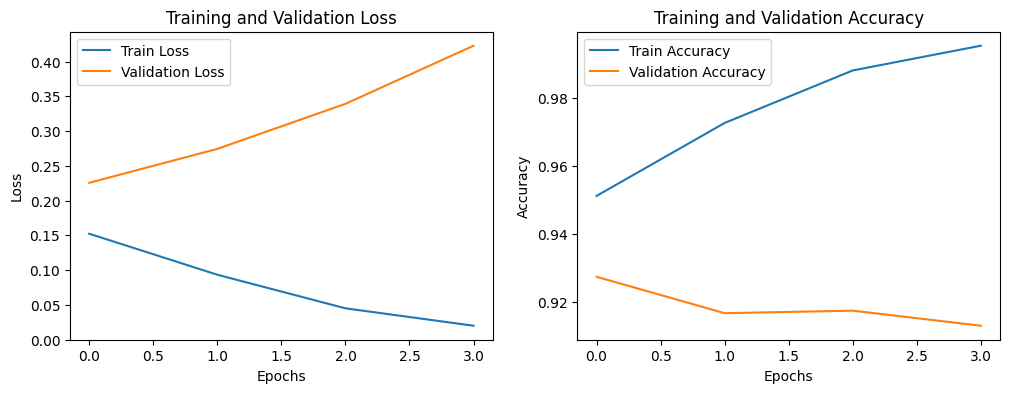

In [ ]:
# Eğitim ve doğrulama kaybı
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Eğitim ve doğrulama doğruluğu
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.savefig('training_and_validation_metrics.png')

plt.show()

# TEST


In [ ]:
# Evaluate model
test_loss, test_accuracy = model.evaluate(test_dataset.batch(batch_size))
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

441/441 [==============================] - 11s 24ms/step - loss: 0.2759 - accuracy: 0.9274
Test Loss: 0.2759
Test Accuracy: 0.9274


In [ ]:
y_pred = model.predict(test_dataset.batch(batch_size))
y_pred_probs = tf.nn.softmax(y_pred.logits, axis=1).numpy()
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true = test['sentiment'].values


441/441 [==============================] - 13s 23ms/step


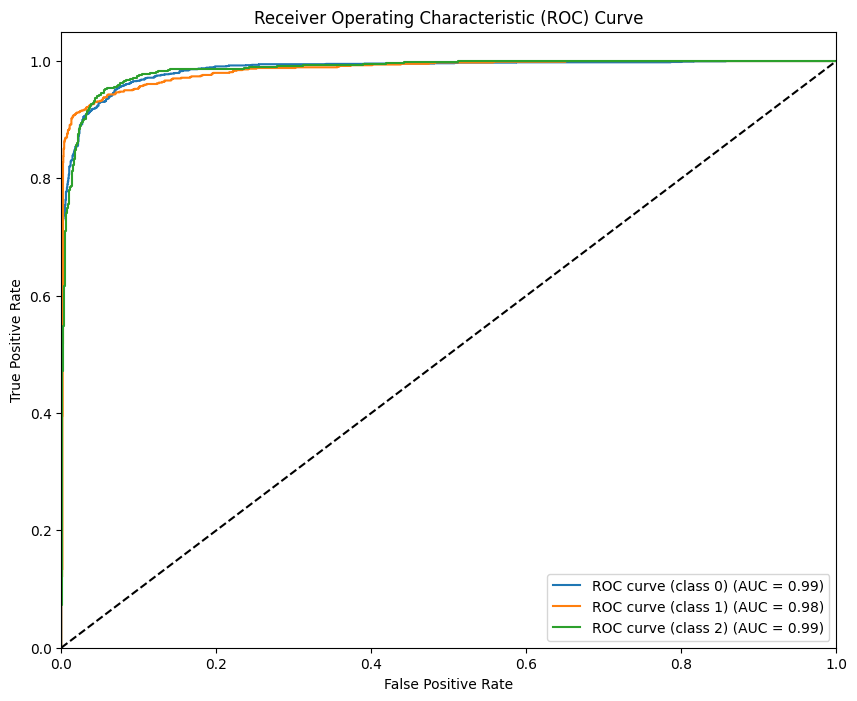

In [ ]:
# AUC-ROC Curve

from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 8))
for i in range(3):  # Assuming 3 classes
    fpr, tpr, _ = roc_curve(y_true == i, y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve (class {i}) (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('roc_curve.png')
plt.show()


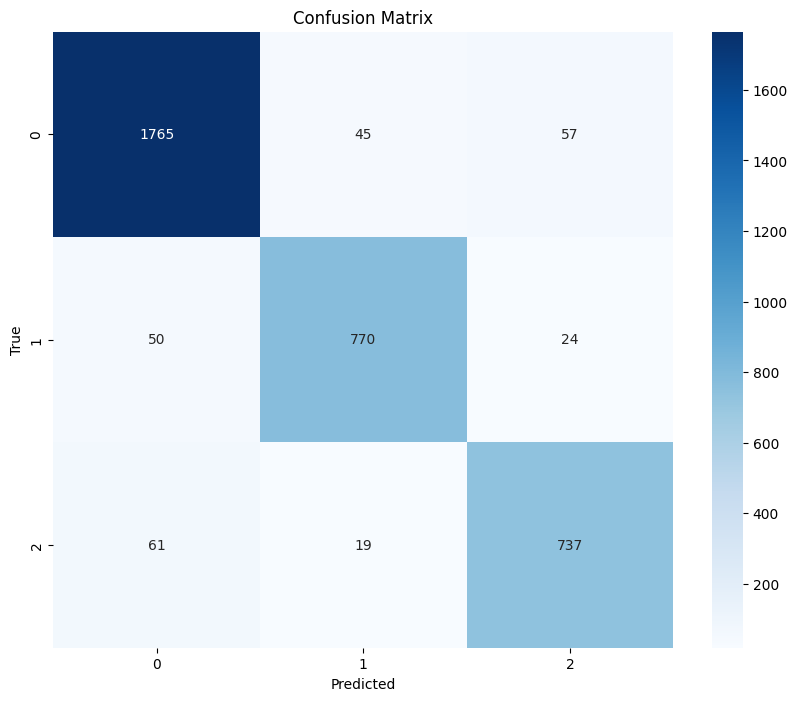


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.94      1867
           1       0.92      0.91      0.92       844
           2       0.90      0.90      0.90       817

    accuracy                           0.93      3528
   macro avg       0.92      0.92      0.92      3528
weighted avg       0.93      0.93      0.93      3528



In [ ]:
# Confusion Matrix

from sklearn.metrics import confusion_matrix, classification_report


cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('confusion_matrix.png')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes))

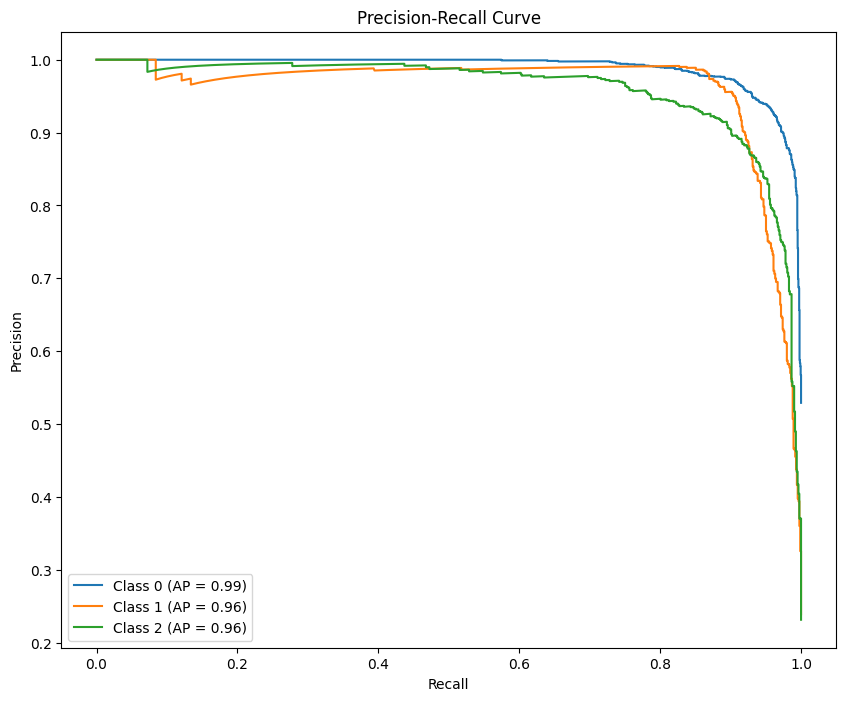

In [ ]:
# Precision-Recall Curve
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(10, 8))
for i in range(3):  # Assuming 3 classes
    precision, recall, _ = precision_recall_curve(y_true == i, y_pred_probs[:, i])
    average_precision = average_precision_score(y_true == i, y_pred_probs[:, i])
    plt.plot(recall, precision, label=f'Class {i} (AP = {average_precision:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.savefig('precision_recall_curve.png')
plt.show()

# Modeli Kaydet


In [ ]:
model_name = "sentiment_8_1e-05_20"
model.save_pretrained(model_name)
tokenizer.save_pretrained(model_name)

('sentiment_8_1e-05_20/tokenizer_config.json',
 'sentiment_8_1e-05_20/special_tokens_map.json',
 'sentiment_8_1e-05_20/vocab.json',
 'sentiment_8_1e-05_20/merges.txt',
 'sentiment_8_1e-05_20/added_tokens.json',
 'sentiment_8_1e-05_20/tokenizer.json')

In [ ]:
from google.colab import files
import shutil

# Model ve tokenizer'ı bir zip dosyasına sıkıştırma
shutil.make_archive("sentiment_8_1e-05_20", 'zip', "./sentiment_8_1e-05_20")

# Zip dosyasını indirme
files.download("sentiment_8_1e-05_20")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# HUGGING FACE YÜKLEME


In [ ]:
model_card = """
---
language: tr
tags:
- turkish
- sentiment
- classification
- tensorflow
license: mit
---

# Turkish Sentiment Analysis Model

This model is a fine-tuned version of [VRLLab/TurkishBERTweet](https://huggingface.co/VRLLab/TurkishBERTweet) for sentiment analysis in Turkish.

## Model description

The model is based on BERT and fine-tuned on a Turkish sentiment analysis dataset. It classifies text into three sentiment categories. Negative, Pozitive and Notr.

## Intended uses & limitations

This model is intended for sentiment analysis of Turkish text. It should be used for research purposes or general sentiment analysis tasks in Turkish.

## Training data

The model was fine-tuned on a combined dataset of labeled Turkish sentiment data.

## Training procedure

The model was fine-tuned using the following hyperparameters:
- learning rate: 1e-5
- batch size: 8
- epochs: 5 (with early stopping)
- optimizer: Adam (beta1=0.9, beta2=0.999, epsilon=1e-8)

## Evaluation results

Test Accuracy: 0.9325

"""

with open(f"{model_name}/README.md", "w", encoding="utf-8") as f:
    f.write(model_card)

In [ ]:
!pip install huggingface_hub

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
from huggingface_hub import HfApi

api = HfApi()
api.create_repo(repo_id="ikball/turkish-sentiment", exist_ok=True)
api.upload_folder(
    folder_path=model_name,
    repo_id="ikball/turkish-sentiment",
    repo_type="model",
)

tf_model.h5:   0%|          | 0.00/652M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/ikball/turkish-sentiment/commit/0a7bd8c6de51132d21e79eec9dc8ceeca2babdf7', commit_message='Upload folder using huggingface_hub', commit_description='', oid='0a7bd8c6de51132d21e79eec9dc8ceeca2babdf7', pr_url=None, pr_revision=None, pr_num=None)